# **Data collecting and processing**

## Imports Needed

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## For warnings

In [67]:
# For warning removal
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Intalltions

In [68]:
! pip install chembl_webresource_client

  Using cached chembl-webresource-client-0.10.2.tar.gz (51 kB)
  Using cached requests_cache-0.5.2-py2.py3-none-any.whl (22 kB)
  Created wheel for chembl-webresource-client: filename=chembl_webresource_client-0.10.2-py3-none-any.whl size=55661 sha256=a690c2a4d186a5885b3e0af541387e255a2c4cd5cb56d697de7b52e07750460b
  Stored in directory: /root/.cache/pip/wheels/6b/b6/01/3ac263f66b426db41f56f1f93e9afab34deea55cefa34b3253
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6349 sha256=d27b86dc2928a482a76651e6f91e97336605bd8d86494ce9277791b9d917807c
  Stored in directory: /root/.cache/pip/wheels/88/96/68/c2be18e7406804be2e593e1c37845f2dd20ac2ce1381ce40b0
Successfully built chembl-webresource-client easydict


### Searching for target(Coronavirus)

In [69]:
from chembl_webresource_client.new_client import new_client

# Target search for coronavirus
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,14.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,14.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,5.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859


### Selecting and retrieving bioactivity

In [70]:
selected_target = targets.target_chembl_id[4]
selected_target

'CHEMBL3927'

In [71]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [72]:
df = pd.DataFrame.from_dict(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '18.28', 'le': '0.33', 'lle': '3.25', ...",CHEMBL187579,None,CHEMBL187579,5.14,False,http://www.openphacts.org/units/Nanomolar,384103,=,1,True,=,None,IC50,nM,None,7200.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '12.10', 'le': '0.33', 'lle': '1.22', ...",CHEMBL188487,None,CHEMBL188487,5.03,False,http://www.openphacts.org/units/Nanomolar,383984,=,1,True,=,None,IC50,nM,None,9400.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '11.56', 'le': '0.29', 'lle': '2.21', ...",CHEMBL185698,None,CHEMBL185698,4.87,False,http://www.openphacts.org/units/Nanomolar,384106,=,1,True,=,None,IC50,nM,None,13500.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.64', 'le': '0.32', 'lle': '1.25', ...",CHEMBL426082,None,CHEMBL426082,4.88,False,http://www.openphacts.org/units/Nanomolar,384075,=,1,True,=,None,IC50,nM,None,13110.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.84', 'le': '0.32', 'lle': '2.16', ...",CHEMBL187717,None,CHEMBL187717,5.70,False,http://www.openphacts.org/units/Nanomolar,384234,=,1,True,=,None,IC50,nM,None,2000.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,None,12041507,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,BAO_0000190,BAO_0000019,assay format,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,None,None,CHEMBL2146458,Bioorg. Med. Chem.,2012,"{'bei': '14.70', 'le': '0.27', 'lle': '1.57', ...",CHEMBL2146517,METHYL TANSHINONATE,CHEMBL2146517,4.97,False,http://www.openphacts.org/units/Nanomolar,1727226,=,1,True,=,None,IC50,nM,None,10600.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.6
129,None,12041508,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,BAO_0000190,B

In [73]:
df.shape

(133, 43)

### Data Cleaning

In [74]:
# Drop the row if standard_value column of the compound is missing 
df2 = df[df.standard_value.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '18.28', 'le': '0.33', 'lle': '3.25', ...",CHEMBL187579,None,CHEMBL187579,5.14,False,http://www.openphacts.org/units/Nanomolar,384103,=,1,True,=,None,IC50,nM,None,7200.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '12.10', 'le': '0.33', 'lle': '1.22', ...",CHEMBL188487,None,CHEMBL188487,5.03,False,http://www.openphacts.org/units/Nanomolar,383984,=,1,True,=,None,IC50,nM,None,9400.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '11.56', 'le': '0.29', 'lle': '2.21', ...",CHEMBL185698,None,CHEMBL185698,4.87,False,http://www.openphacts.org/units/Nanomolar,384106,=,1,True,=,None,IC50,nM,None,13500.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.64', 'le': '0.32', 'lle': '1.25', ...",CHEMBL426082,None,CHEMBL426082,4.88,False,http://www.openphacts.org/units/Nanomolar,384075,=,1,True,=,None,IC50,nM,None,13110.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.84', 'le': '0.32', 'lle': '2.16', ...",CHEMBL187717,None,CHEMBL187717,5.70,False,http://www.openphacts.org/units/Nanomolar,384234,=,1,True,=,None,IC50,nM,None,2000.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,None,12041507,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,BAO_0000190,BAO_0000019,assay format,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,None,None,CHEMBL2146458,Bioorg. Med. Chem.,2012,"{'bei': '14.70', 'le': '0.27', 'lle': '1.57', ...",CHEMBL2146517,METHYL TANSHINONATE,CHEMBL2146517,4.97,False,http://www.openphacts.org/units/Nanomolar,1727226,=,1,True,=,None,IC50,nM,None,10600.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,10.6
129,None,12041508,[],CHEMBL2150313,Inhibition of SARS-CoV PLpro expressed in Esch...,B,BAO_0000190,B

## Data pre-processing of bioactivity data

### Labeling the compounds acctive,inactive or intermediate

In [75]:
df2['standard_value'] = df['standard_value'].astype(float)

In [76]:
bioactivity_class = []
for i in df2.standard_value:
    if i >= 10000:
        bioactivity_class.append("inactive")
    elif i <= 1000:
        bioactivity_class.append("active")
    else:
        bioactivity_class.append("intermediate")

### Combining label with the data

In [77]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0
...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0


In [78]:
bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


# **Descriptors for the compounds**

### **Install conda and rdkit**

In [79]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-10-11 21:15:31--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   180MB/s    in 0.5s    

2020-10-11 21:15:31 (180 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-p

### **Viewing Data**

In [80]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df4,'canonical_smiles','Molecule')

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,Molecule
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,
...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive,
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive,
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive,
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive,

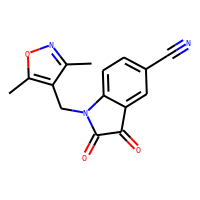
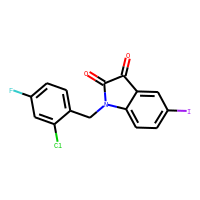
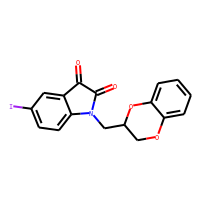
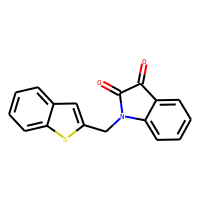
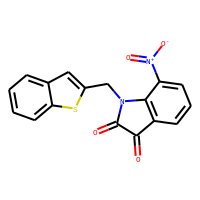
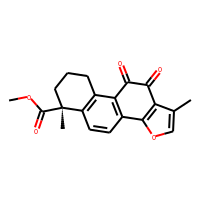
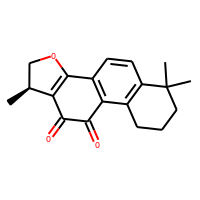
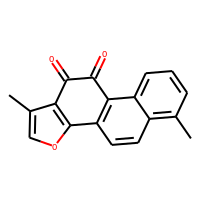
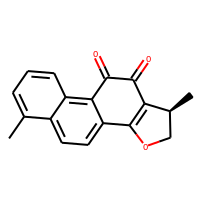
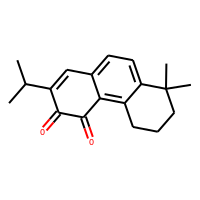

In [81]:
df4

### **Convert IC50 to pIC50**
   * To uniformly distribute the data

In [82]:
# For converting:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [83]:
# For normalizing:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

,molecule_chembl_id,canonical_smiles,bioactivity_class,Molecule,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,,13500.0

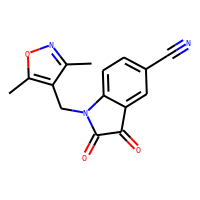
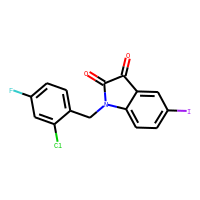
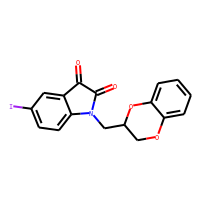

In [84]:
df_norm = norm_value(df4)
df_norm.head(3)

In [85]:
# After normalising

df_norm.standard_value_norm.describe()

count    1.330000e+02
mean     2.110164e+07
std      4.089714e+07
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      1.000000e+08
Name: standard_value_norm, dtype: float64

,molecule_chembl_id,canonical_smiles,bioactivity_class,Molecule,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,,5.698970
...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,,4.974694
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,,4.995679
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,,4.939302
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,,4.970616

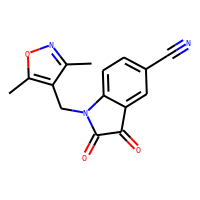
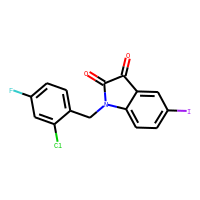
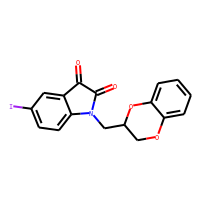
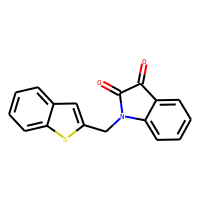
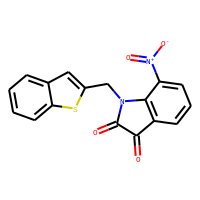
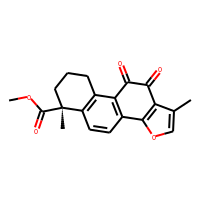
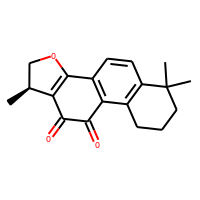
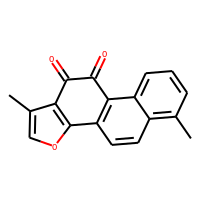
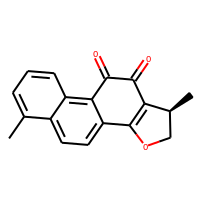
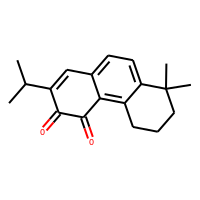

In [86]:
df_final = pIC50(df_norm)
df_final

#### ***Removing intermediate class***

,molecule_chembl_id,canonical_smiles,bioactivity_class,Molecule,pIC50
0,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,,4.869666
1,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,,4.882397
2,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,,6.008774
3,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,,6.022276
4,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,,4.950782
...,...,...,...,...,...
114,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,,4.974694
115,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,,4.995679
116,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,,4.939302
117,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,,4.970616

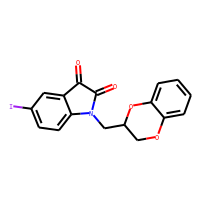
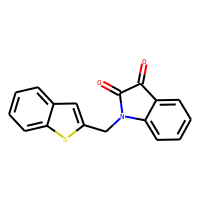
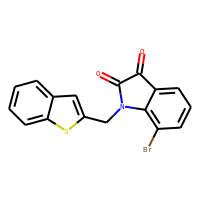
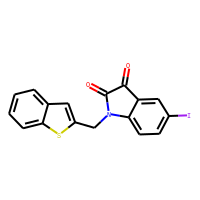
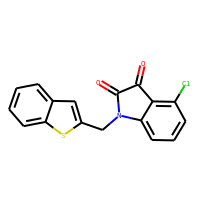
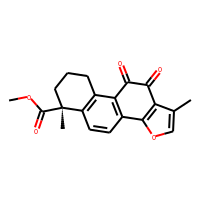
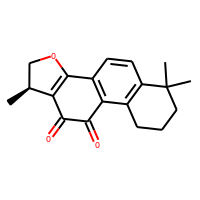
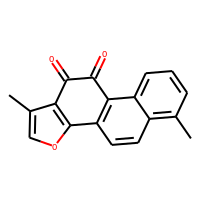
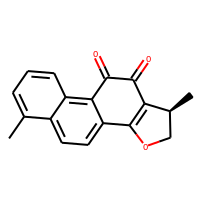
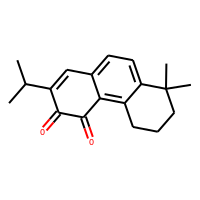

In [87]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class = df_2class.reset_index()
df_2class =  df_2class.drop('index',1)
df_2class

## ***Mordred Descriptors***

### Install and imports

In [88]:
! pip install git+https://github.com/mordred-descriptor/mordred

  Cloning https://github.com/mordred-descriptor/mordred to /tmp/pip-req-build-e6e7zat1
  Running command git clone -q https://github.com/mordred-descriptor/mordred /tmp/pip-req-build-e6e7zat1
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=177678 sha256=961b41066b952e462b167adb72c92b83a6641c2d3d583a66c351ba069d24e85b
  Stored in directory: /tmp/pip-ephem-wheel-cache-i9ecr_gq/wheels/23/ba/54/7121909af62418bda56701656ffbec9c5d7c289a8c120bdd4d
Successfully built mordred


In [89]:
from rdkit import Chem                            # imports the Chem module from rdkit
from mordred import Calculator, descriptors       # imports mordred descriptor library

### Descriptor Calculator

In [90]:
calc = Calculator(descriptors)    # sets up a function reading descriptors
print("The module will calculate",len(calc.descriptors),"desriptors per molecule")

The module will calculate 1826 desriptors per molecule


In [91]:
smiles = df_2class['canonical_smiles']

In [92]:
output = pd.DataFrame()
c = 1
for i in smiles:
  result = calc(Chem.MolFromSmiles(i))
  result_dict = result.drop_missing().asdict()
  output = output.append(result_dict, ignore_index=True)
  print("Molecule",c,"Done")
  c += 1
print("Completed.")

Molecule 1 Done
Molecule 2 Done
Molecule 3 Done
Molecule 4 Done
Molecule 5 Done
Molecule 6 Done
Molecule 7 Done
Molecule 8 Done
Molecule 9 Done
Molecule 10 Done
Molecule 11 Done
Molecule 12 Done
Molecule 13 Done
Molecule 14 Done
Molecule 15 Done
Molecule 16 Done
Molecule 17 Done
Molecule 18 Done
Molecule 19 Done
Molecule 20 Done
Molecule 21 Done
Molecule 22 Done
Molecule 23 Done
Molecule 24 Done
Molecule 25 Done
Molecule 26 Done
Molecule 27 Done
Molecule 28 Done
Molecule 29 Done
Molecule 30 Done
Molecule 31 Done
Molecule 32 Done
Molecule 33 Done
Molecule 34 Done
Molecule 35 Done
Molecule 36 Done
Molecule 37 Done
Molecule 38 Done
Molecule 39 Done
Molecule 40 Done
Molecule 41 Done
Molecule 42 Done
Molecule 43 Done
Molecule 44 Done
Molecule 45 Done
Molecule 46 Done
Molecule 47 Done
Molecule 48 Done
Molecule 49 Done
Molecule 50 Done
Molecule 51 Done
Molecule 52 Done
Molecule 53 Done
Molecule 54 Done
Molecule 55 Done
Molecule 56 Done
Molecule 57 Done
Molecule 58 Done
Molecule 59 Done
Molecu

In [93]:
output

,AATS0Z,AATS0are,AATS0d,AATS0dv,AATS0i,AATS0m,AATS0p,AATS0pe,AATS0s,AATS0se,AATS0v,AATS1Z,AATS1are,AATS1d,AATS1dv,AATS1i,AATS1m,AATS1p,AATS1pe,AATS1s,AATS1se,AATS1v,AATS2Z,AATS2are,AATS2d,AATS2dv,AATS2i,AATS2m,AATS2p,AATS2pe,AATS2s,AATS2se,AATS2v,AATS3Z,AATS3are,AATS3d,AATS3dv,AATS3i,AATS3m,AATS3p,...,MAXaaN,MAXaaO,MAXsCH3,MDEC-11,MDEC-12,MDEC-13,MDEN-22,MINaaN,MINaaO,MINsCH3,MAXsNH2,MDEN-13,MINsNH2,MAXssS,MINssS,MAXddsN,MAXsOH,MAXtN,MAXtsC,MDEN-12,MINddsN,MINsOH,MINtN,MINtsC,MAXsF,MAXssssC,MDEC-14,MDEC-24,MDEC-34,MINsF,MINssssC,MAXddssS,MDEN-11,MINddssS,MAXaasN,MINaasN,MAXdsN,MINdsN,MAXaaNH,MINaaNH
0,106.800000,6.503971,4.000000,10.314977,155.336855,565.414154,2.432913,6.636403,5.522075,8.003889,278.254195,36.315789,6.501316,4.736842,9.490058,141.971041,148.301546,2.117539,6.685026,3.387788,7.900097,305.306893,34.707692,6.577431,4.307692,8.275897,148.725603,141.808137,1.912167,6.727140,3.433583,8.022477,269.997083,30.261905,6.564488,3.511905,6.786772,154.747145,119.525559,1.672098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33.000000,6.230266,4.031250,9.201389,152.470958,131.238825,1.975264,6.354616,5.347329,7.741900,275.455671,31.200000,6.270714,4.742857,8.609524,139.166496,121.281587,2.215313,6.463157,3.250617,7.688643,315.310165,29.568966,6.279190,4.465517,7.793103,143.760995,113.850063,2.068058,6.449502,3.193114,7.730962,287.470278,24.791667,6.201067,3.555556,6.199074,148.508519,92.649016,1.755245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.250000,6.313628,4.187500,9.422239,151.053715,330.727361,2.252073,6.477166,5.313317,7.855759,296.465819,37.028571,6.309286,4.914286,8.839153,138.592335,148.356440,2.329026,6.518529,3.209259,7.737836,327.626464,36.603448,6.325741,4.620690,8.031290,143.068043,146.526609,2.205298,6.516329,3.158897,7.790332,302.334777,34.236111,6.278092,3.708333,6.422840,147.252995,135.424894,1.924280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,120.750000,6.231644,4.187500,9.420895,150.105683,634.480339,2.855823,6.424478,5.310710,7.773113,307.522657,40.114286,6.271429,4.885714,8.798730,138.153975,164.485659,2.438769,6.496671,3.204183,7.703236,331.150374,40.327586,6.280052,4.586207,7.929885,142.538988,165.992907,2.337746,6.489950,3.162264,7.748574,306.587772,34.902778,6.202372,3.652778,6.325309,146.335325,138.178076,2.059236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42.000000,6.329294,4.187500,9.439043,151.947264,170.479027,2.109882,6.515416,5.334474,7.909311,290.233397,33.942857,6.315714,4.914286,8.898413,138.963549,133.101098,2.287515,6.533100,3.222634,7.757921,325.231859,32.879310,6.333500,4.620690,8.076628,143.516059,128.114989,2.155198,6.533916,3.178569,7.814573,299.444736,29.013889,6.285942,3.694444,6.567901,148.093415,110.367990,1.874553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,24.604651,6.357442,3.767442,9.255814,157.945611,97.288641,1.558071,6.426465,5.804425,7.872122,235.158124,26.086957,6.336957,4.565217,8.630435,141.136753,99.839610,1.912741,6.498620,3.294384,7.754465,284.309142,22.915663,6.251566,4.289157,7.578313,148.892974,87.296238,1.694046,6.376489,3.151606,7.73

### Cleaning data

In [94]:
des_data = output.dropna(axis = 1, how = 'any')
des_data.shape

(119, 1166)

In [95]:
des_data = pd.concat([des_data,df_2class['bioactivity_class']],axis = 1)
des_data

,AATS0Z,AATS0are,AATS0d,AATS0dv,AATS0i,AATS0m,AATS0p,AATS0pe,AATS0se,AATS0v,AATS1Z,AATS1are,AATS1d,AATS1dv,AATS1i,AATS1m,AATS1p,AATS1pe,AATS1se,AATS1v,AATS2Z,AATS2are,AATS2d,AATS2dv,AATS2i,AATS2m,AATS2p,AATS2pe,AATS2se,AATS2v,AATS3Z,AATS3are,AATS3d,AATS3dv,AATS3i,AATS3m,AATS3p,AATS3pe,AATS3se,AATS3v,...,nG12AHRing,nG12ARing,nG12FAHRing,nG12FARing,nG12FHRing,nG12FRing,nG12FaHRing,nG12FaRing,nG12HRing,nG12Ring,nG12aHRing,nG12aRing,nH,nHBAcc,nHBDon,nHRing,nHeavyAtom,nHetero,nI,nN,nO,nP,nRing,nRot,nS,nSpiro,nX,naHRing,naRing,piPC1,piPC10,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,bioactivity_class
0,106.800000,6.503971,4.000000,10.314977,155.336855,565.414154,2.432913,6.636403,8.003889,278.254195,36.315789,6.501316,4.736842,9.490058,141.971041,148.301546,2.117539,6.685026,7.900097,305.306893,34.707692,6.577431,4.307692,8.275897,148.725603,141.808137,1.912167,6.727140,8.022477,269.997083,30.261905,6.564488,3.511905,6.786772,154.747145,119.525559,1.672098,6.688219,8.081267,226.584048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,4.0,0.0,2.0,23.0,6.0,1.0,1.0,4.0,0.0,4.0,2.0,0.0,0.0,1.0,0.0,2.0,3.555348,6.575424,4.143135,4.718499,5.235111,5.750984,5.840278,6.090036,6.332669,6.443734,inactive
1,33.000000,6.230266,4.031250,9.201389,152.470958,131.238825,1.975264,6.354616,7.741900,275.455671,31.200000,6.270714,4.742857,8.609524,139.166496,121.281587,2.215313,6.463157,7.688643,315.310165,29.568966,6.279190,4.465517,7.793103,143.760995,113.850063,2.068058,6.449502,7.730962,287.470278,24.791667,6.201067,3.555556,6.199074,148.508519,92.649016,1.755245,6.345318,7.735603,237.764813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,3.0,0.0,2.0,21.0,4.0,0.0,1.0,2.0,0.0,4.0,2.0,1.0,0.0,0.0,1.0,3.0,3.555348,7.403599,4.200954,4.856901,5.460383,5.952756,6.170885,6.578850,6.989375,7.035688,inactive
2,71.250000,6.313628,4.187500,9.422239,151.053715,330.727361,2.252073,6.477166,7.855759,296.465819,37.028571,6.309286,4.914286,8.839153,138.592335,148.356440,2.329026,6.518529,7.737836,327.626464,36.603448,6.325741,4.620690,8.031290,143.068043,146.526609,2.205298,6.516329,7.790332,302.334777,34.236111,6.278092,3.708333,6.422840,147.252995,135.424894,1.924280,6.454462,7.833815,255.898975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,0.0,2.0,22.0,5.0,0.0,1.0,2.0,0.0,4.0,2.0,1.0,0.0,1.0,1.0,3.0,3.583519,7.461986,4.244917,4.902493,5.510147,6.010501,6.243408,6.625050,7.039917,7.118301,active
3,120.750000,6.231644,4.187500,9.420895,150.105683,634.480339,2.855823,6.424478,7.773113,307.522657,40.114286,6.271429,4.885714,8.798730,138.153975,164.485659,2.438769,6.496671,7.703236,331.150374,40.327586,6.280052,4.586207,7.929885,142.538988,165.992907,2.337746,6.489950,7.748574,306.587772,34.902778,6.202372,3.652778,6.325309,146.335325,138.178076,2.059236,6.406012,7.763182,257.337146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,0.0,2.0,22.0,5.0,1.0,1.0,2.0,0.0,4.0,2.0,1.0,0.0,1.0,1.0,3.0,3.583519,7.466339,4.244917,4.891289,5.497936,6.012339,6.252115,6.641702,7.041395,7.080690,active
4,42.000000,6.329294,4.187500,9.439043,151.947264,170.479027,2.109882,6.515416,7.909311,290.233397,33.942857,6.315714,4.914286,8.898413,138.963549,133.101098,2.287515,6.533100,7.757921,325.231859,32.879310,6.333500,4.620690,8.076628,143.516059,128.114989,2.155198,6.533916,7.814573,299.444736,29.013889,6.285942,3.694444,6.567901,148.093415,110.367990,1.874553,6.476651,7.868421,253.540581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,0.0,2.0,22.0,5.0,0.0,1.0,2.0,0.0,4.0,2.0,1.0,0.0,1.0,1.0,3.0,3.583519,7.473553,4.244917,4.902493,5.516197,6.001260,6.236094,6.623308,7.044098,7.116248,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,24.604651

### Frequency plot of the 2 bioactivity classes

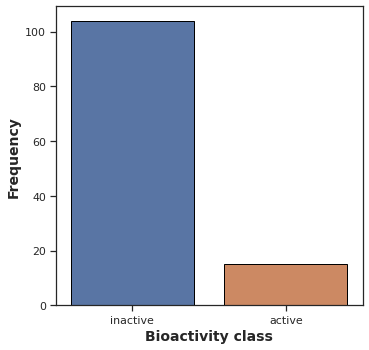

In [96]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Statistical analysis | Mann-Whitney U Test

In [97]:
def mannwhitney(descriptor, verbose=False):
    try:
      # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
      from numpy.random import seed
      from numpy.random import randn
      from scipy.stats import mannwhitneyu

      # seed the random number generator
      seed(1)
      
      # actives and inactives
      selection = [descriptor, 'bioactivity_class']
      df = des_data[selection]
      active = df[df.bioactivity_class == 'active']
      active = active[descriptor]

      selection = [descriptor, 'bioactivity_class']
      df = des_data[selection]
      inactive = df[df.bioactivity_class == 'inactive']
      inactive = inactive[descriptor]

      # compare samples
      stat, p = mannwhitneyu(active, inactive)
      #print('Statistics=%.3f, p=%.3f' % (stat, p))

      # interpret
      alpha = 0.05
      if p > alpha:
          interpretation = 1 #'Same distribution (fail to reject H0)'
      else:
          interpretation = 0 #'Different distribution (reject H0)'
    
      results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index=[0])
      #filename = 'mannwhitneyu_' + descriptor + '.csv'
      #results.to_csv(filename)
    except:
      results = pd.DataFrame({'Descriptor':'NaN',
                            'Statistics':'NaN',
                            'p':'NaN',
                            'alpha':'NaN',
                            'Interpretation':0}, index=[0])

    return results

In [98]:
col = des_data.columns

In [99]:
frames = []
ana = pd.DataFrame
for i in col:
  frames.append(mannwhitney(i))
  
  
ana = pd.concat(frames)

In [100]:
p = ana[ana.Interpretation !=0]
p = p.reset_index()
p =  p.drop('index',1)
p.head()

,Descriptor,Statistics,p,alpha,Interpretation
0,AATS1se,587.5,0.0620917,0.05,1
1,AATS3d,601,0.0764559,0.05,1
2,AATS3p,643.5,0.138078,0.05,1
3,AATS4i,575.5,0.0511826,0.05,1
4,AATS4p,679.5,0.211643,0.05,1


In [101]:
feat = p['Descriptor']

In [102]:
mor_data = pd.concat([des_data[feat],df_2class['pIC50']],axis = 1)
mor_data

,AATS1se,AATS3d,AATS3p,AATS4i,AATS4p,AATS7are,AATS7dv,AATS7se,AATS8are,AATS8d,AATS8dv,AATS8pe,AATS8se,AATSC0are,AATSC0d,AATSC0dv,AATSC0p,AATSC0pe,AATSC1are,AATSC1c,AATSC1pe,AATSC1se,AATSC2i,AATSC2p,AATSC3d,AATSC3i,AATSC4d,AATSC4dv,AATSC4pe,AATSC4se,AATSC5Z,AATSC5d,AATSC5dv,AATSC5i,AATSC5m,AATSC6are,AATSC6d,AATSC6dv,AATSC6p,AATSC6pe,...,n5aRing,n6AHRing,n6ARing,n6HRing,n6aHRing,n6aRing,n9FAHRing,n9FARing,nAHRing,nARing,nAcid,nAromAtom,nAromBond,nBase,nBondsA,nBondsD,nBondsKD,nBondsM,nF,nFAHRing,nFARing,nG12FAHRing,nG12FARing,nG12FHRing,nG12FRing,nHRing,nI,nO,nRing,naHRing,naRing,piPC10,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,pIC50
0,7.900097,3.511905,1.672098,156.260194,1.569879,6.284945,6.081212,7.867779,6.216273,3.272727,5.710101,6.398634,7.788824,0.156451,0.656327,4.395411,0.701846,0.139730,-0.001576,-0.010612,0.000083,-0.004286,-0.064537,0.015444,-0.088639,0.048054,-0.140630,-1.129364,-0.027561,-0.017822,3.134297,-0.051693,-0.606862,-0.359720,16.260963,0.013165,0.117203,0.526679,0.028455,0.018112,...,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,0.0,12.0,12.0,0.0,12.0,2.0,8.0,14.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0,0.0,2.0,6.575424,4.718499,5.235111,5.750984,5.840278,6.090036,6.332669,6.443734,4.869666
1,7.688643,3.555556,1.755245,152.508936,1.591362,6.073814,5.976744,7.628938,6.139692,3.128205,5.076923,6.271538,7.661100,0.103094,0.631836,3.756944,0.307233,0.096801,0.000814,-0.005749,0.001599,-0.000721,0.042360,0.015144,-0.138346,-0.283934,-0.130075,-0.712050,-0.010886,-0.008201,-0.323093,0.051956,-0.721281,-0.064770,-1.666634,-0.015206,0.128380,0.196581,0.038753,-0.011169,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,15.0,16.0,0.0,16.0,2.0,9.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,1.0,3.0,7.403599,4.856901,5.460383,5.952756,6.170885,6.578850,6.989375,7.035688,4.882397
2,7.737836,3.708333,1.924280,151.034980,1.837967,6.164233,6.164513,7.746814,6.208923,3.282051,5.270655,6.370923,7.749395,0.102630,0.671875,3.792604,0.386123,0.099962,0.000246,-0.005794,0.000765,-0.001226,0.072374,0.023480,-0.119792,-0.333529,-0.176276,-0.680399,-0.012790,-0.011284,-5.145988,0.062235,-0.729597,-0.230275,-27.176839,-0.015579,0.159856,0.217280,0.135799,-0.009554,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,15.0,16.0,0.0,16.0,2.0,9.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,1.0,3.0,7.461986,4.902493,5.510147,6.010501,6.243408,6.625050,7.039917,7.118301,6.008774
3,7.703236,3.652778,2.059236,150.907904,1.855653,6.075419,6.076486,7.663240,6.140959,3.307692,5.296676,6.332046,7.688299,0.102925,0.671875,3.806628,0.788345,0.094537,0.000803,-0.005821,0.001082,-0.000878,0.094855,0.030436,-0.123264,-0.333753,-0.111136,-0.596625,-0.012310,-0.008857,3.570710,0.045286,-0.643285,-0.189106,17.763729,-0.015008,0.121394,0.154809,0.038080,-0.002552,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,15.0,16.0,0.0,16.0,2.0,9.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,4.0,1.0,3.0,7.466339,4.891289,5.497936,6.012339,6.252115,6.641702,7.041395,7.080690,6.022276
4,7.757921,3.694444,1.874553,151.937906,1.717295,6.146191,6.229113,7.746049,6.256000,3.230769,5.390313,6.451231,7.844130,0.104269,0.671875,3.732253,0.317469,0.106607,0.000156,-0.005606,0.000561,-0.001413,0.053043,0.020570,-0.133681,-0.272229,-0.153389,-0.629325,0.005134,0.004044,-0.399364,0.047405,-0.759939,-0.078715,-2.010275,-0.022136,0.138221,0.141619,0.016126,-0.022308,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,15.0,16.0,0.0,16.0,2.0,9.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,1.0,3.0,7.473553,4.902493,5.516197,6.001260,6.236094,6.623308,7.044098,7.116248,4.950782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,7.754465,3.869159,1.636771,154.284276,1.408736,6.280588,3.952941,7.868576,6.

### Interpretation of Statistical Results

Of all the Mordred descriptors, only 379 exhibited no difference between the actives and inactives while the other shows statistically significant difference between actives and inactives.

## ***PaDEL-Descriptor***

### **Download PaDEL-Descriptor**

In [103]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2020-10-11 21:18:27--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2020-10-11 21:18:27--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip.1’

padel.zip.1         100%[===================>]  24.57M  39.7MB/s    in 0.6s    

2020-10-11 21:18:28 (39.7 MB/s) - ‘padel.zip.1’ saved [25768637/25768637]

--2020-10-11 21:18:28--  https://github

In [175]:
! unzip padel.zip

Archive:  padel.zip
replace __MACOSX/._PaDEL-Descriptor? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._PaDEL-Descriptor  
replace PaDEL-Descriptor/MACCSFingerprinter.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
replace __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/Klekota

### **Preparing bioactivity data**

In [176]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df_2class[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)
df3_selection

,canonical_smiles,molecule_chembl_id
0,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,CHEMBL185698
1,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,CHEMBL426082
2,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,CHEMBL365134
3,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,CHEMBL190743
4,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,CHEMBL365469
...,...,...
114,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,CHEMBL2146517
115,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,CHEMBL187460
116,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,CHEMBL363535
117,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,CHEMBL227075


In [177]:
! cat molecule.smi | head -5

O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21	CHEMBL185698
O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21	CHEMBL426082
O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21	CHEMBL365134
O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21	CHEMBL190743
O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21	CHEMBL365469


In [178]:
! cat molecule.smi | wc -l

119


### **Calculate fingerprint descriptors**

#### ***Calculate PaDEL descriptors***

In [179]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [180]:
! bash padel.sh

Processing CHEMBL185698 in molecule.smi (1/119). 
Processing CHEMBL426082 in molecule.smi (2/119). 
Processing CHEMBL365134 in molecule.smi (3/119). Average speed: 2.38 s/mol.
Processing CHEMBL365469 in molecule.smi (5/119). Average speed: 1.07 s/mol.
Processing CHEMBL190743 in molecule.smi (4/119). Average speed: 1.27 s/mol.
Processing CHEMBL191575 in molecule.smi (7/119). Average speed: 1.00 s/mol.
Processing CHEMBL188983 in molecule.smi (6/119). Average speed: 0.87 s/mol.
Processing CHEMBL370923 in molecule.smi (8/119). Average speed: 0.71 s/mol.
Processing CHEMBL194398 in molecule.smi (9/119). Average speed: 0.70 s/mol.
Processing CHEMBL196635 in molecule.smi (10/119). Average speed: 0.62 s/mol.
Processing CHEMBL209287 in molecule.smi (11/119). Average speed: 0.61 s/mol.
Processing CHEMBL348660 in molecule.smi (13/119). Average speed: 0.53 s/mol.
Processing CHEMBL358279 in molecule.smi (12/119). Average speed: 0.57 s/mol.
Processing CHEMBL379727 in molecule.smi (14/119). Average sp

#### ***Preparing the X and Y Data Matrices***

##### *X data matrix*

In [110]:
df3_X = pd.read_csv('descriptors_output.csv')
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL185698,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL426082,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL190743,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL365134,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL188983,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,CHEMBL187460,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
115,CHEMBL2146517,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116,CHEMBL227075,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
117,CHEMBL363535,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
115,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
117,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### *Y variable*
  Converted IC50 to pIC50

In [112]:
df3_Y = df_2class['pIC50']
df3_Y

0      4.869666
1      4.882397
2      6.008774
3      6.022276
4      4.950782
         ...   
114    4.974694
115    4.995679
116    4.939302
117    4.970616
118    4.102923
Name: pIC50, Length: 119, dtype: float64

##### *Combining X and Y variable*

In [113]:
pad_data = pd.concat([df3_X,df3_Y], axis=1)
pad_data

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.869666
1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.882397
2,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.008774
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.022276
4,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.950782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.974694
115,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.995679
116,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.939302
117,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.970616


# **Models**

## ***Import libraries***

In [114]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor

## ***Data set processing and spliting***

### **Mordred data**

#### *Input features*

In [115]:
X = mor_data.drop('pIC50', axis=1)
X

,AATS1se,AATS3d,AATS3p,AATS4i,AATS4p,AATS7are,AATS7dv,AATS7se,AATS8are,AATS8d,AATS8dv,AATS8pe,AATS8se,AATSC0are,AATSC0d,AATSC0dv,AATSC0p,AATSC0pe,AATSC1are,AATSC1c,AATSC1pe,AATSC1se,AATSC2i,AATSC2p,AATSC3d,AATSC3i,AATSC4d,AATSC4dv,AATSC4pe,AATSC4se,AATSC5Z,AATSC5d,AATSC5dv,AATSC5i,AATSC5m,AATSC6are,AATSC6d,AATSC6dv,AATSC6p,AATSC6pe,...,n5aHRing,n5aRing,n6AHRing,n6ARing,n6HRing,n6aHRing,n6aRing,n9FAHRing,n9FARing,nAHRing,nARing,nAcid,nAromAtom,nAromBond,nBase,nBondsA,nBondsD,nBondsKD,nBondsM,nF,nFAHRing,nFARing,nG12FAHRing,nG12FARing,nG12FHRing,nG12FRing,nHRing,nI,nO,nRing,naHRing,naRing,piPC10,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9
0,7.900097,3.511905,1.672098,156.260194,1.569879,6.284945,6.081212,7.867779,6.216273,3.272727,5.710101,6.398634,7.788824,0.156451,0.656327,4.395411,0.701846,0.139730,-0.001576,-0.010612,0.000083,-0.004286,-0.064537,0.015444,-0.088639,0.048054,-0.140630,-1.129364,-0.027561,-0.017822,3.134297,-0.051693,-0.606862,-0.359720,16.260963,0.013165,0.117203,0.526679,0.028455,0.018112,...,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,0.0,12.0,12.0,0.0,12.0,2.0,8.0,14.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0,0.0,2.0,6.575424,4.718499,5.235111,5.750984,5.840278,6.090036,6.332669,6.443734
1,7.688643,3.555556,1.755245,152.508936,1.591362,6.073814,5.976744,7.628938,6.139692,3.128205,5.076923,6.271538,7.661100,0.103094,0.631836,3.756944,0.307233,0.096801,0.000814,-0.005749,0.001599,-0.000721,0.042360,0.015144,-0.138346,-0.283934,-0.130075,-0.712050,-0.010886,-0.008201,-0.323093,0.051956,-0.721281,-0.064770,-1.666634,-0.015206,0.128380,0.196581,0.038753,-0.011169,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,15.0,16.0,0.0,16.0,2.0,9.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,1.0,3.0,7.403599,4.856901,5.460383,5.952756,6.170885,6.578850,6.989375,7.035688
2,7.737836,3.708333,1.924280,151.034980,1.837967,6.164233,6.164513,7.746814,6.208923,3.282051,5.270655,6.370923,7.749395,0.102630,0.671875,3.792604,0.386123,0.099962,0.000246,-0.005794,0.000765,-0.001226,0.072374,0.023480,-0.119792,-0.333529,-0.176276,-0.680399,-0.012790,-0.011284,-5.145988,0.062235,-0.729597,-0.230275,-27.176839,-0.015579,0.159856,0.217280,0.135799,-0.009554,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,15.0,16.0,0.0,16.0,2.0,9.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,1.0,3.0,7.461986,4.902493,5.510147,6.010501,6.243408,6.625050,7.039917,7.118301
3,7.703236,3.652778,2.059236,150.907904,1.855653,6.075419,6.076486,7.663240,6.140959,3.307692,5.296676,6.332046,7.688299,0.102925,0.671875,3.806628,0.788345,0.094537,0.000803,-0.005821,0.001082,-0.000878,0.094855,0.030436,-0.123264,-0.333753,-0.111136,-0.596625,-0.012310,-0.008857,3.570710,0.045286,-0.643285,-0.189106,17.763729,-0.015008,0.121394,0.154809,0.038080,-0.002552,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,15.0,16.0,0.0,16.0,2.0,9.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,4.0,1.0,3.0,7.466339,4.891289,5.497936,6.012339,6.252115,6.641702,7.041395,7.080690
4,7.757921,3.694444,1.874553,151.937906,1.717295,6.146191,6.229113,7.746049,6.256000,3.230769,5.390313,6.451231,7.844130,0.104269,0.671875,3.732253,0.317469,0.106607,0.000156,-0.005606,0.000561,-0.001413,0.053043,0.020570,-0.133681,-0.272229,-0.153389,-0.629325,0.005134,0.004044,-0.399364,0.047405,-0.759939,-0.078715,-2.010275,-0.022136,0.138221,0.141619,0.016126,-0.022308,...,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,15.0,16.0,0.0,16.0,2.0,9.0,18.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,1.0,3.0,7.473553,4.902493,5.516197,6.001260,6.236094,6.623308,7.044098,7.116248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,7.754465,3.869159,1.636771,154.284276,1.408736,6.280588,3.952941,7.868576,6.363788,2.363636,3.9545

In [116]:
X.shape

(119, 379)

#### *Output features*

In [117]:
Y = mor_data['pIC50']
Y.head(3)

0    4.869666
1    4.882397
2    6.008774
Name: pIC50, dtype: float64

In [181]:
Y.shape

(119,)

#### *Data split (80/20 ratio)*

In [119]:
Xm_train, Xm_test, Ym_train, Ym_test = train_test_split(X, Y, test_size=0.2)

In [120]:
Xm_train.shape, Ym_train.shape

((95, 379), (95,))

In [121]:
Xm_test.shape, Ym_test.shape

((24, 379), (24,))

### **PaDEL data**

#### *Input features*

In [182]:
X = pad_data.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
115,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
117,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [183]:
X.shape

(119, 881)

#### *Output features*

In [184]:
Y = pad_data['pIC50']
Y

0      4.869666
1      4.882397
2      6.008774
3      6.022276
4      4.950782
         ...   
114    4.974694
115    4.995679
116    4.939302
117    4.970616
118    4.102923
Name: pIC50, Length: 119, dtype: float64

In [185]:
Y.shape

(119,)

#### *Data split (80/20 ratio)*

In [186]:
Xp_train, Xp_test, Yp_train, Yp_test = train_test_split(X, Y, test_size=0.2)

In [187]:
Xp_train.shape, Yp_train.shape

((95, 881), (95,))

In [188]:
Xp_test.shape, Yp_test.shape

((24, 881), (24,))

## ***Regression using Random Forest***

### **Model training and predicting**

#### *For Mordred data*

In [189]:
np.random.seed(100)
rfm = RandomForestRegressor(n_estimators=100)
rfm.fit(Xm_train, Ym_train)
r2_rfm = rfm.score(Xm_test, Ym_test)
r2_rfm

0.2506390079677737

In [190]:
Yrm_pred = rfm.predict(Xm_test)

##### Model analysis

In [191]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Ym_test, Yrm_pred)
rms = metrics.mean_squared_error(Ym_test, Yrm_pred)
vs = metrics.explained_variance_score(Ym_test, Yrm_pred)
r2 = metrics.r2_score(Ym_test, Yrm_pred)
print(mae,rms,vs,r2)

1.4926186742068086 3.1831322895315015 0.25250115671477924 0.2506390079677737


#### *For PaDEL data*

In [192]:
np.random.seed(100)
rfp = RandomForestRegressor(n_estimators=100)
rfp.fit(Xp_train, Yp_train)
r2_rfp = rfp.score(Xp_test, Yp_test)
r2_rfp

0.12942952626690107

In [193]:
Yrp_pred = rfp.predict(Xp_test)

##### Model analysis

In [194]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Yp_test, Yrp_pred)
rms = metrics.mean_squared_error(Yp_test, Yrp_pred)
vs = metrics.explained_variance_score(Yp_test, Yrp_pred)
r2 = metrics.r2_score(Yp_test, Yrp_pred)
print(mae,rms,vs,r2)

0.9733699104300912 1.6735559236712862 0.1887758616798918 0.12942952626690107


### **Scatter Plot of Experimental vs Predicted pIC50 Values**

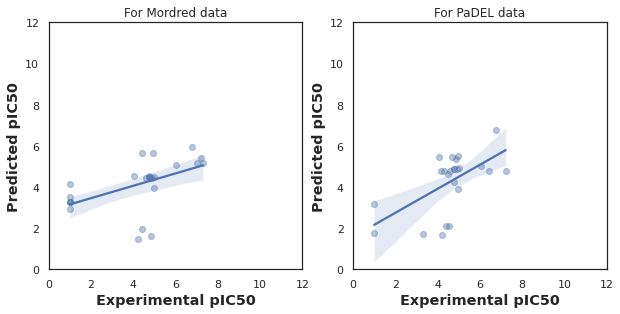

In [195]:
sns.set(color_codes=True)
sns.set_style("white")

plt.subplot(221)
plt.title('For Mordred data')
ax = sns.regplot(Ym_test, Yrm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(10, 10)

plt.subplot(222)
plt.title('For PaDEL data')
ax = sns.regplot(Yp_test, Yrp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
#ax.figure.set_size_inches(10, 10)

plt.show()

## ***Regression using Support Vector Regression***

### **Model training and predicting**

#### *For Mordred data*

In [136]:
svrm = SVR(kernel='rbf')
svrm.fit(Xm_train, Ym_train)
r2_svrm = svrm.score(Xm_test, Ym_test)
r2_svrm

0.08235954177547478

In [137]:
Ysm_pred = svrm.predict(Xm_test)

##### Model analysis

In [138]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Ym_test, Ysm_pred)
rms = metrics.mean_squared_error(Ym_test, Ysm_pred)
vs = metrics.explained_variance_score(Ym_test, Ysm_pred)
r2 = metrics.r2_score(Ym_test, Ysm_pred)
print(mae,rms,vs,r2)

1.5345931965806834 3.897949057681071 0.08252318393149305 0.08235954177547478


#### *For PaDEL data*

In [139]:
svrp = SVR(kernel='rbf')
svrp.fit(Xp_train, Yp_train)
r2_svrp = svrp.score(Xp_test, Yp_test)
r2_svrp

0.279464602815251

In [140]:
Ysp_pred = rfp.predict(Xp_test)

##### Model analysis

In [141]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Yp_test, Ysp_pred)
rms = metrics.mean_squared_error(Yp_test, Ysp_pred)
vs = metrics.explained_variance_score(Yp_test, Ysp_pred)
r2 = metrics.r2_score(Yp_test, Ysp_pred)
print(mae,rms,vs,r2)

1.0041413585850354 1.841571803719205 0.4724404829024974 0.4188505735106315


### **Scatter Plot of Experimental vs Predicted pIC50 Values**

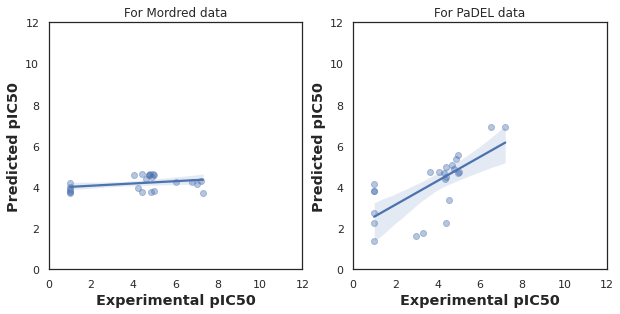

In [142]:
sns.set(color_codes=True)
sns.set_style("white")

plt.subplot(221)
plt.title('For Mordred data')
ax = sns.regplot(Ym_test, Ysm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(10, 10)

plt.subplot(222)
plt.title('For PaDEL data')
ax = sns.regplot(Yp_test, Ysp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
#ax.figure.set_size_inches(10, 10)

plt.show()

## ***Regression using Decision Tree Regression***

### **Model training and predicting**

#### *For Mordred data*

In [143]:
dtreem = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
dtreem.fit(Xm_train, Ym_train)
r2_dtreem = dtreem.score(Xm_test, Ym_test)
r2_dtreem

0.3873120547517105

In [144]:
Ydm_pred = dtreem.predict(Xm_test)

##### Model analysis

In [145]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Ym_test, Ydm_pred)
rms = metrics.mean_squared_error(Ym_test, Ydm_pred)
vs = metrics.explained_variance_score(Ym_test, Ydm_pred)
r2 = metrics.r2_score(Ym_test, Ydm_pred)
print(mae,rms,vs,r2)

1.4230203668033747 2.602573129190407 0.4192703422135968 0.3873120547517105


#### *For PaDEL data*

In [146]:
dtreep = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
dtreep.fit(Xp_train, Yp_train)
r2_dtreep = dtreep.score(Xp_test, Yp_test)
r2_dtreep

0.5136909950397026

In [147]:
Ydp_pred = rfp.predict(Xp_test)

##### Model analysis

In [148]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Yp_test, Ydp_pred)
rms = metrics.mean_squared_error(Yp_test, Ydp_pred)
vs = metrics.explained_variance_score(Yp_test, Ydp_pred)
r2 = metrics.r2_score(Yp_test, Ydp_pred)
print(mae,rms,vs,r2)

1.0041413585850354 1.841571803719205 0.4724404829024974 0.4188505735106315


### **Scatter Plot of Experimental vs Predicted pIC50 Values**

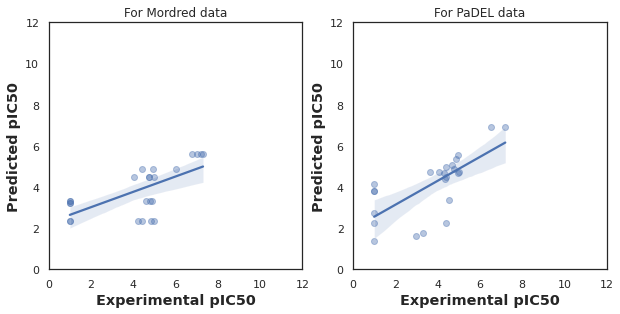

In [149]:
sns.set(color_codes=True)
sns.set_style("white")

plt.subplot(221)
plt.title('For Mordred data')
ax = sns.regplot(Ym_test, Ydm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(10, 10)

plt.subplot(222)
plt.title('For PaDEL data')
ax = sns.regplot(Yp_test, Ydp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
#ax.figure.set_size_inches(10, 10)

plt.show()

## ***Regression using KNeighbors Regressor***

### **Model training and predicting**

#### *For Mordred data*

In [150]:
knm = KNeighborsRegressor(n_neighbors=5)
knm.fit(Xm_train, Ym_train) 
r2_knm = knm.score(Xm_test, Ym_test)
r2_knm

0.22719956285729648

In [151]:
Ykm_pred = knm.predict(Xm_test)

##### Model analysis

In [152]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Ym_test, Ykm_pred)
rms = metrics.mean_squared_error(Ym_test, Ykm_pred)
vs = metrics.explained_variance_score(Ym_test, Ykm_pred)
r2 = metrics.r2_score(Ym_test, Ykm_pred)
print(mae,rms,vs,r2)

1.4269510329685355 3.2826982602361157 0.26140863540030024 0.22719956285729648


#### *For PaDEL data*

In [153]:
knp = KNeighborsRegressor(n_neighbors=5)
knp.fit(Xp_train, Yp_train) 
r2_knp = knp.score(Xp_test, Yp_test)
r2_knp

0.6419637917254151

In [154]:
Ykp_pred = rfp.predict(Xp_test)

##### Model analysis

In [155]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Yp_test, Ykp_pred)
rms = metrics.mean_squared_error(Yp_test, Ykp_pred)
vs = metrics.explained_variance_score(Yp_test, Ykp_pred)
r2 = metrics.r2_score(Yp_test, Ykp_pred)
print(mae,rms,vs,r2)

1.0041413585850354 1.841571803719205 0.4724404829024974 0.4188505735106315


### **Scatter Plot of Experimental vs Predicted pIC50 Values**

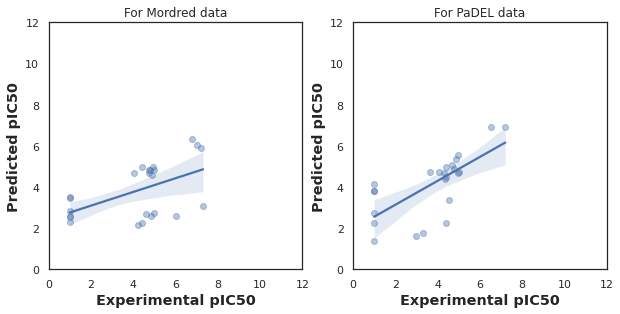

In [156]:
sns.set(color_codes=True)
sns.set_style("white")

plt.subplot(221)
plt.title('For Mordred data')
ax = sns.regplot(Ym_test, Ykm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(10, 10)

plt.subplot(222)
plt.title('For PaDEL data')
ax = sns.regplot(Yp_test, Ykp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
#ax.figure.set_size_inches(10, 10)

plt.show()

## ***Regression using Adabooster Regressor***

### **Model training and predicting**

#### *For Mordred data*

In [157]:
adbm = AdaBoostRegressor(random_state=0, n_estimators=100)
adbm.fit(Xm_train, Ym_train)
r2_adbm = adbm.score(Xm_test, Ym_test)
r2_adbm

0.39474487149505844

In [158]:
Yadm_pred = adbm.predict(Xm_test)

##### Model analysis

In [159]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Ym_test, Yadm_pred)
rms = metrics.mean_squared_error(Ym_test, Yadm_pred)
vs = metrics.explained_variance_score(Ym_test, Yadm_pred)
r2 = metrics.r2_score(Ym_test, Yadm_pred)
print(mae,rms,vs,r2)

1.3048877562503118 2.5710000432818956 0.40336766080029873 0.39474487149505844


#### *For PaDEL data*

In [160]:
adbp = AdaBoostRegressor(random_state=0, n_estimators=100)
adbp.fit(Xp_train, Yp_train)
r2_adbp = adbp.score(Xp_test, Yp_test)
r2_adbp

0.5823654830700108

In [161]:
Yadp_pred = adbp.predict(Xp_test)

##### Model analysis

In [162]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Yp_test, Yadp_pred)
rms = metrics.mean_squared_error(Yp_test, Yadp_pred)
vs = metrics.explained_variance_score(Yp_test, Yadp_pred)
r2 = metrics.r2_score(Yp_test, Yadp_pred)
print(mae,rms,vs,r2)

0.8495190401525887 1.3234185832105076 0.6412174545854554 0.5823654830700108


### **Scatter Plot of Experimental vs Predicted pIC50 Values**

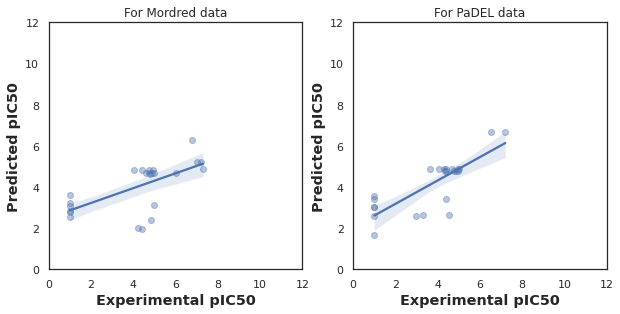

In [163]:
sns.set(color_codes=True)
sns.set_style("white")

plt.subplot(221)
plt.title('For Mordred data')
ax = sns.regplot(Ym_test, Yadm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(10, 10)

plt.subplot(222)
plt.title('For PaDEL data')
ax = sns.regplot(Yp_test, Yadp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
#ax.figure.set_size_inches(10, 10)

plt.show()

## ***Ensemble using Voting regressor***

### **Model training and predicting**

#### *For Mordred data*

In [164]:
erm = VotingRegressor([('adb', adbm),('dt', dtreem), ('kn', knm)])
erm.fit(Xm_train, Ym_train)
r2_erm = erm.score(Xm_test, Ym_test)
r2_erm

0.3854579894055593

In [165]:
Yem_pred = erm.predict(Xm_test)

##### Model analysis

In [166]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Ym_test, Yem_pred)
rms = metrics.mean_squared_error(Ym_test, Yem_pred)
vs = metrics.explained_variance_score(Ym_test, Yem_pred)
r2 = metrics.r2_score(Ym_test, Yem_pred)
print(mae,rms,vs,r2)

1.377937533273677 2.6104488197227234 0.40862128036662027 0.3854579894055593


#### *For PaDEL data*

In [167]:
erp = VotingRegressor([('adb', adbp),('dt', dtreep), ('kn', knp)])
erp.fit(Xp_train, Yp_train)
r2_erp = erp.score(Xp_test, Yp_test)
r2_erp

0.6308121683831618

In [168]:
Yep_pred = erp.predict(Xp_test)

##### Model analysis

In [169]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Yp_test, Yep_pred)
rms = metrics.mean_squared_error(Yp_test, Yep_pred)
vs = metrics.explained_variance_score(Yp_test, Yep_pred)
r2 = metrics.r2_score(Yp_test, Yep_pred)
print(mae,rms,vs,r2)

0.8616502894032884 1.1698986009310648 0.6649851195328419 0.6308121683831618


### **Scatter Plot of Experimental vs Predicted pIC50 Values**

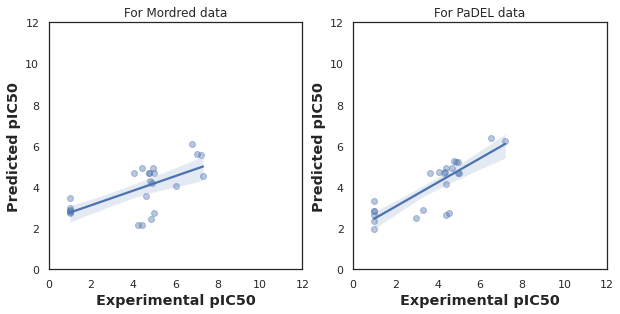

In [170]:
sns.set(color_codes=True)
sns.set_style("white")

plt.subplot(221)
plt.title('For Mordred data')
ax = sns.regplot(Ym_test, Yem_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(10, 10)

plt.subplot(222)
plt.title('For PaDEL data')
ax = sns.regplot(Yp_test, Yep_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
#ax.figure.set_size_inches(10, 10)

plt.show()

# **All model visual and info**

## *For Mordred data*

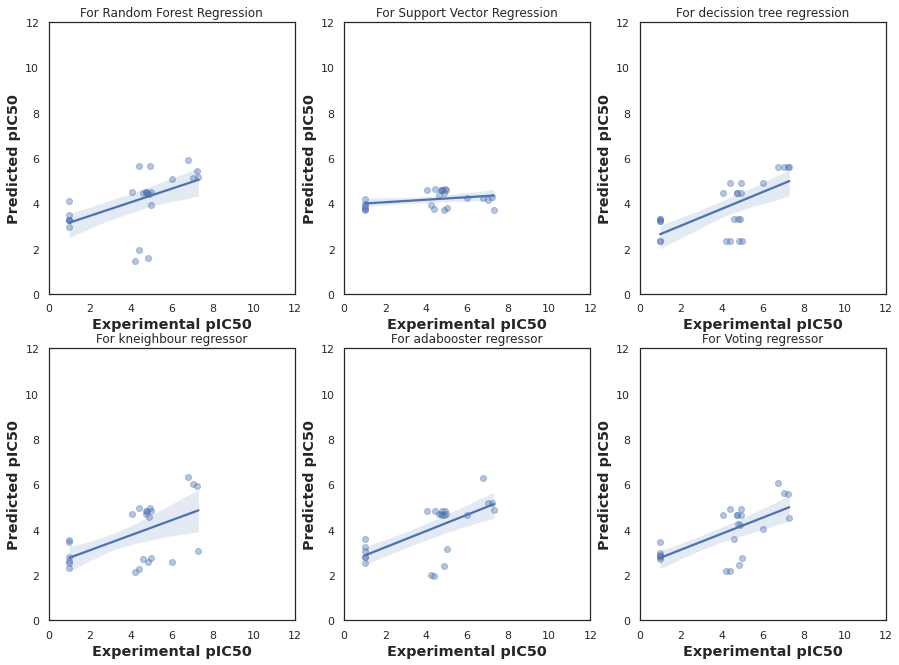

In [171]:
plt.figure(figsize=(15, 11))

# For Random Forest Regression

plt.subplot(231)
plt.title('For Random Forest Regression')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Ym_test, Yrm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)


# For Support Vector Regression

plt.subplot(232)
plt.title('For Support Vector Regression')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Ym_test, Ysm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)


# For decission tree regression

plt.subplot(233)
plt.title('For decission tree regression')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Ym_test, Ydm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)


# For kneighbour regressor

plt.subplot(234)
plt.title('For kneighbour regressor')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Ym_test, Ykm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)


# For adabooster regressor

plt.subplot(235)
plt.title('For adabooster regressor')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Ym_test, Yadm_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

# For Voting regressor

plt.subplot(236)
plt.title('For Voting regressor')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Ym_test, Yem_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

plt.show()

In [172]:
print("The r2 scores of models are:")
print('Random Forest Regression\t',r2_rfm)
print('Support Vector Regression\t',r2_svrm)
print('Decision tree Regression\t',r2_dtreem)
print('KNeighbour Regression\t',r2_knm)
print('Adabooster Regressor\t',r2_adbm)
print('Voting Regressor\t',r2_erm)

The r2 scores of models are:
Random Forest Regression	 0.2506390079677737
Support Vector Regression	 0.08235954177547478
Decision tree Regression	 0.3873120547517105
KNeighbour Regression	 0.22719956285729648
Adabooster Regressor	 0.39474487149505844
Voting Regressor	 0.3854579894055593


## *For PaDEL data*

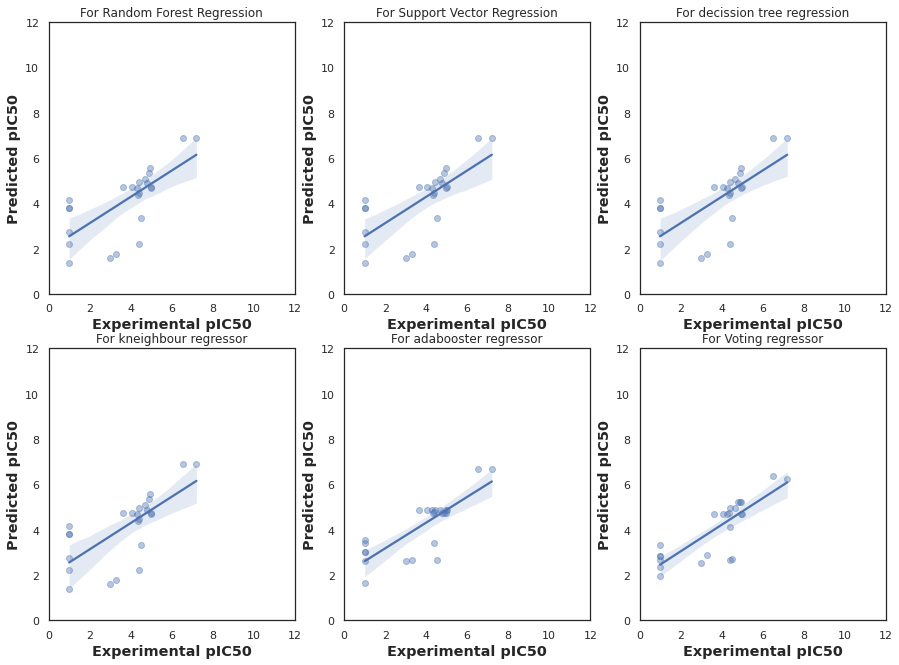

In [173]:
plt.figure(figsize=(15, 11))

# For Random Forest Regression

plt.subplot(231)
plt.title('For Random Forest Regression')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Yp_test, Yrp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)


# For Support Vector Regression

plt.subplot(232)
plt.title('For Support Vector Regression')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Yp_test, Ysp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)


# For decission tree regression

plt.subplot(233)
plt.title('For decission tree regression')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Yp_test, Ydp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)


# For kneighbour regressor

plt.subplot(234)
plt.title('For kneighbour regressor')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Yp_test, Ykp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)


# For adabooster regressor

plt.subplot(235)
plt.title('For adabooster regressor')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Yp_test, Yadp_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

# For Voting regressor

plt.subplot(236)
plt.title('For Voting regressor')

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Yp_test, Yep_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

plt.show()

In [174]:
print("The r2 scores of models are:")
print('Random Forest Regression\t',r2_rfp)
print('Support Vector Regression\t',r2_svrp)
print('Decision tree Regression\t',r2_dtreep)
print('KNeighbour Regression\t',r2_knp)
print('Adabooster Regressor\t',r2_adbp)
print('Voting Regressor\t',r2_erp)

The r2 scores of models are:
Random Forest Regression	 0.4188505735106315
Support Vector Regression	 0.279464602815251
Decision tree Regression	 0.5136909950397026
KNeighbour Regression	 0.6419637917254151
Adabooster Regressor	 0.5823654830700108
Voting Regressor	 0.6308121683831618
